In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0,'/home/bradhakrishnan/ECE276A_PR1/code/')

In [3]:
import motion_calibration
import grad_descent
import load_data

imud, vicd, camd= load_data.load_dataset(1)

Data import took: 0.007933855056762695 sec.



In [14]:
imud[1,:300].mean()

jnp.mean(imud[1:,:], axis=1)

Array([-508.55022143, -497.11727192,  583.16775908,  373.73906112,
        375.59007972,  370.03454384], dtype=float64)

In [13]:
import jax
import jax.numpy as jnp
import quaternion_ops as qops 
jax.config.update("jax_enable_x64", True)

calibrated_imu= motion_calibration.calibrate_v2(1,300)
# calibrated_imu[1:4, :] = jnp.multiply(calibrated_imu[1:4, :] , jnp.array([-1, -1, 1])[:, jnp.newaxis])


Dataset 1 :: 

Data import took: 0.012166023254394531 sec.

Dataset 1 :: 

Data import took: 0.008359193801879883 sec.

[-508.55022143 -497.11727192  583.16775908  373.73906112  375.59007972
  370.03454384]


In [5]:
qts = jnp.zeros((4, calibrated_imu.shape[1]), dtype=jnp.float64)
qts = qts.at[0, 0].set(1)

In [6]:
del_t= (calibrated_imu[0,1:]-calibrated_imu[0,:-1])
w_vec= calibrated_imu[4:,:]

In [9]:
exp_vec = jax.vmap(qops.qexp, in_axes=(1), out_axes=1)
exp_terms=exp_vec(jnp.vstack((jnp.zeros(w_vec.shape[1]-1), del_t*w_vec[:, :-1]/2)))


In [69]:
def motion_model(w_vec, qts, del_t):
    exp_vec = jax.vmap(qops.qexp, in_axes=(1), out_axes=1)
    exp_terms=exp_vec(jnp.vstack((jnp.zeros(w_vec.shape[1]-1), del_t*w_vec[:, :-1]/2)))
    for i in range(w_vec.shape[1]-1):
        qts = qts.at[:, i+1].set(qops.qmult(qts[:, i], exp_terms[:, i]))
    return qts, exp_terms

def motion_model_vec(qt,exp_term):
    return qops.qmult(qt, exp_term)
    

In [70]:
grad_descent.plt_graph_imu(calibrated_imu, qts, epoch)

NameError: name 'epoch' is not defined

In [144]:
qts,exp_terms= motion_model(w_vec, qts, del_t)

In [76]:
linear_acc= jnp.vstack((jnp.zeros(w_vec.shape[1]), calibrated_imu[1:4,:]))

In [77]:

    # return qops.qmult(qops.qmult(qops.qinverse(q), jnp.array([0., 0., 0., 1.0])),q)


hts= jax.vmap(obs_model, in_axes=(1), out_axes=1)
fts= jax.vmap(motion_model_vec, in_axes=(1,1), out_axes=1)
obs_model_ops= hts(qts)
motion_model_ops= fts(qts[:, :-1], exp_terms)

NameError: name 'exp_terms' is not defined

# Grad descent

In [69]:
qts.shape , exp_terms.shape

((4, 5645), (4, 5644))

In [74]:
def compute_rot_error(qt_1, ft):
    return  jnp.pow(2 * (jnp.linalg.norm(qops.qlog(qops.qmult(qops.qinverse(qt_1), ft)))), 2)

def compute_pos_error(at, ht):
    return jnp.pow(jnp.linalg.norm(at-ht),2)

rot_error_vec = jax.vmap(compute_rot_error, in_axes=(1, 1))
# rot_error_vec(qts[:,1:],fts(qts[:,:-1],exp_terms)).sum()

pos_error_vec= jax.vmap(compute_pos_error, in_axes=(1,1))
# pos_error_vec(linear_acc[:,1:],hts(qts[:,1:])).sum()


def compute_cost(qts,linear_acc,exp_terms, rot_error_vec=jax.vmap(compute_rot_error, in_axes=(1, 1)), pos_error_vec=jax.vmap(compute_pos_error, in_axes=(1,1))):
    return 0.5*(rot_error_vec(qts[:,1:],fts(qts[:,:-1],exp_terms)).sum()+pos_error_vec(linear_acc[:,1:],hts(qts[:,1:])).sum())

def normalize_q(q,epsilon=1e-6):
    norm= jnp.linalg.norm(q)
    return q/norm
normalized_vec= jax.vmap(normalize_q, in_axes=(1), out_axes=1)


In [126]:
compute_cost(qts, linear_acc)

Array(326219.7343601, dtype=float64)

In [6]:
import quaternion_ops as qops
import transforms3d as t3d


def motion_model_rollover(calibrated_imu):
    pred_qts= [jnp.array([1,0,0,0])]
    exp_vals=[]
    for idx in range(0,calibrated_imu.shape[1]-1):
        exp_term= calibrated_imu[4:,idx]* (calibrated_imu[0,idx+1]- calibrated_imu[0,idx])/2
        exp_val= t3d.quaternions.qexp(jnp.concatenate((jnp.array([0]),exp_term)))
        exp_vals.append(exp_val)
        pred_qts.append(t3d.quaternions.qmult(pred_qts[idx],exp_val))
    pred_qts= jnp.column_stack(pred_qts)
    exp_vals=jnp.column_stack(exp_vals)
    return pred_qts, exp_vals

In [7]:
qts,exp_vals= motion_model_rollover(calibrated_imu)

In [17]:
linear_acc= jnp.vstack((jnp.zeros(calibrated_imu.shape[1]), calibrated_imu[1:4,:]))
linear_acc.shape

(4, 5645)

In [49]:
def obs_model(q):
    return qops.qmult(qops.qinverse(q),qops.qmult(jnp.array([0., 0., 0., -9.8]),q))

def motion_model(q,exp):
    return qops.qmult(q, exp)

def rotation_err(qt_1, ft):
    return jnp.linalg.norm(2*qops.qlog(qops.qmult(qops.qinverse(qt_1), ft))) **2

def position_err(at, ht):
    return jnp.linalg.norm(at-ht) **2

hts= jax.vmap(obs_model, in_axes=(1), out_axes=1)
fts= jax.vmap(motion_model, in_axes=(1,1), out_axes=1)

rot_error_vec=jax.vmap(rotation_err, in_axes=(1,1))
pos_error_vec= jax.vmap(position_err, in_axes=(1,1))



In [46]:
jnp.linalg.norm(qts[:,1])

Array(1., dtype=float64)

In [42]:
fts(qts[:,:-1], exp_vals).shape

(4, 5644)

In [57]:
def vector_normalize(q):
    return q/ jnp.linalg.norm(q)
    
def cost_fn(qts, linear_acc, exp_vals):
    return (pos_error_vec(linear_acc[:,1:], hts(qts[:,1:])).sum()+rot_error_vec(qts[:,1:],fts(qts[:,:-1], exp_vals)).sum())/2

In [ ]:
from tqdm import tqdm
norm_vec= jax.vmap(vector_normalize, in_axes=(1),out_axes=1)
grads=[]

pred_qts= qts
step_size= 0.025
epochs=500
epsilon= 1e-9
for epoch in tqdm(range(epochs)):
    cost=cost_fn(pred_qts,linear_acc,exp_vals)
    grad= jax.jacrev(cost_fn)(pred_qts,linear_acc,exp_vals)
    pred_qts=norm_vec(pred_qts- (grad*step_size))
    grads.append(cost)

 69%|██████▉   | 345/500 [01:25<00:39,  3.97it/s]

In [8]:
pred_roll=[0]* calibrated_imu.shape[-1]
pred_pitch=[0]*  calibrated_imu.shape[-1] 
pred_yaw =[0]* calibrated_imu.shape[-1]

for idx in range(0,calibrated_imu.shape[-1]):    
    pred_roll[idx], pred_pitch[idx], pred_yaw[idx] = jnp.array(
t3d.euler.quat2euler(qts[:, idx], 'sxyz')
) * (180 / jnp.pi)

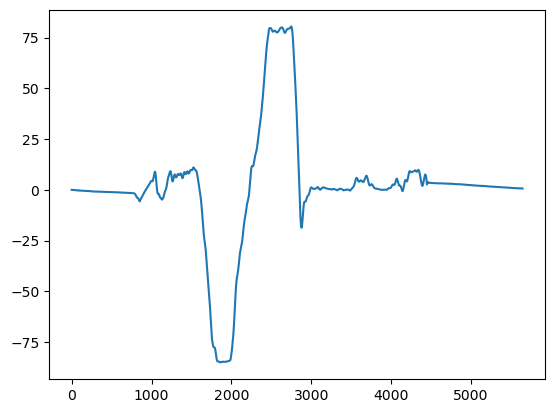

In [10]:
import matplotlib.pyplot as plt
plt.plot(pred_pitch)